In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from geopy import distance
#!pip install geopandas
import geopandas
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from keras.utils import np_utils

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
#from tensorflow.keras import Sequential
#from tensorflow.keras import Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from keras import metrics

from keras.utils import np_utils

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

# Assignment 4 - Simple Neural Networks

For this assigment you'll do a realistic task - predicting fraud from transaction data. 
### Some Things to Note

<ul>
<li> The dataset is imbalanced. See: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data for some ideas
<li> The locations, time, dob all likely aren't super useful on their own, but can be made into something more useful without much code or trouble. Think about how it may be useful to represent them. The data doesn't have missing rows, so this is the main data prep portion. 
<li> With respect to the above, and the other data here, we have a lot of rows of data. That means that we can generally handle data that is reasonably wide...
</ul>

### Deliverables

Your final goal is to produce a function that can be called to classify a transaction:
<ul>
<li> Please submit two .ipynb files - one where you did your work, and another that can use your model to make predictions. 
<li> In that prediction file, please ensure:
    <ul>
    <li> You have a function where I can load a file, and the end result is a classificaiton matrix of your prediction accuracy. 
    <li> You load a trained model. There's no training here. 
    <li> Any data prep stuff that is needed for your data should be built in here. I'm going to run a test file that is the exact same setup as the training data.
    <li> I should be able to open the prediction file, load the test data, and click RUN ALL and things should work. 
    <li> In addition to that, please include a short (~1-2 paragraph) description of what you did. Include anything that was innovative/different as well as a note on:
        <ul>
        <li> Any imbalanced data steps. 
        <li> Treatment of the location and time variables. What did you do to them?
        <li> Model structure (layers/size)
        <li> Any optimization steps included - regularization, dropouts, feature selection, etc...
        </ul>
    </ul>
</ul>

### Grades

The grade breakdown is as follows:

<ul>
<li> Code preduces predictions - 40
<li> Accuracy - 30
<li> Explaination - 20
<li> Balance/variable transformations - 10
</ul>



In [36]:
# Load some data
df = pd.read_csv("https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/fraudTrain.csv.zip")
df.drop(columns={"Unnamed: 0"}, inplace=True)
df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [37]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
trans_date_trans_time,1296675,1274791,2019-04-22 16:02:01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc_num,1296675.0,NaN,NaN,NaN,417192042079641088.0,1308806447000789248.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0
merchant,1296675,693,fraud_Kilback LLC,4403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,1296675,14,gas_transport,131659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amt,1296675.0,NaN,NaN,NaN,70.351035,160.316039,1.0,9.65,47.52,83.14,28948.9
first,1296675,352,Christopher,26669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,1296675,481,Smith,28794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,1296675,2,F,709863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
street,1296675,983,0069 Robin Brooks Apt. 695,3123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,1296675,894,Birmingham,5617,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Deal with Lat/Lon

We can utilize lat/lon of the home and merchant in a useful way?

Note: I left the section headers in from when I did it. You can remove them if you want. 

In [38]:
#Create new column for distance(in kilometers) between home and merchant. Use geopy to calculate distance based on latitude and longitude values. 
def distance_km(x):
    home = (x['lat'], x['long'])
    merch = (x['merch_lat'], x['merch_long'])
    return distance.distance(home, merch).km

df['distance_km'] = df.apply(lambda x: distance_km(x), axis=1)



### Deal with Time

Can we make date/time and the date of birth into something useful?

In [39]:
#Convert the features 'trans_date_trans_time' and 'dob' into datetime datatype, then create a new feature to calculate age of the person at the time of the transaction, called 'age_transaction'. 
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

df['age_transaction'] = df.apply(lambda x: (x['trans_date_trans_time'] - x['dob']).days // 365, axis=1)


### Check Target Balance

In [40]:
#Calculate how many rows are fraud out of the total rows, by percentage. Most transactions are not fraud, very few are frauds. 
neg, pos = np.bincount(df['is_fraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1296675
    Positive: 7506 (0.58% of total)



### Prepare Data


In [41]:
#Drop columns that are not useful for modelling. These are determined based on judgement. 
df.drop(columns=['trans_date_trans_time','cc_num','merchant','first','last','street','lat','long','dob','trans_num','merch_lat','merch_long','job','city'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   category         1296675 non-null  object 
 1   amt              1296675 non-null  float64
 2   gender           1296675 non-null  object 
 3   state            1296675 non-null  object 
 4   zip              1296675 non-null  int64  
 5   city_pop         1296675 non-null  int64  
 6   unix_time        1296675 non-null  int64  
 7   is_fraud         1296675 non-null  int64  
 8   distance_km      1296675 non-null  float64
 9   age_transaction  1296675 non-null  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 98.9+ MB


In [42]:
#Encode Categorical features
df = pd.get_dummies(df,drop_first=True)
df

,amt,zip,city_pop,unix_time,is_fraud,distance_km,age_transaction,category_food_dining,category_gas_transport,category_grocery_net,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,4.97,28654,3495,1325376018,0,78.773821,30,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,107.23,99160,149,1325376044,0,30.216618,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,220.11,83252,4154,1325376051,0,108.102912,56,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,45.00,59632,1939,1325376076,0,95.685115,52,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,41.96,24433,99,1325376186,0,77.702395,32,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,84735,258,1371816728,0,119.696415,58,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1296671,51.70,21790,100,1371816739,0,75.202184,40,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1296672,105.93,88325,899,1371816752,0,98.987927,52,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1296673,74.90,57756,1126,1371816816,0,84.688356,39,1,0,0,...,1,0,0,0,0,0,0,0,0,0


### Split Data

In [43]:
#Split Data
train_df, test_df = train_test_split(df, test_size=0.2)


train_labels = np.array(train_df.pop('is_fraud'))
test_labels = np.array(test_df.pop('is_fraud'))

train_features = np.array(train_df)
test_features = np.array(test_df)

In [44]:
#Normalize Data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

print('Training features shape:', train_features.shape)
print('Training labels shape:', train_labels.shape)
print('Test features shape:', test_features.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (1037340, 70)
Training labels shape: (1037340,)
Test features shape: (259335, 70)
Test labels shape: (259335,)


### Model

In [45]:
#Plot loss function
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                1136      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4150/4150 [==============================] - 11s 2ms/step - loss: 0.0302 - precision: 0.2245 - recall: 0.0180 - auc: 0.7919 - prc: 0.1268 - val_loss: 0.0242 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8699 - val_prc: 0.3192
Epoch 2/50
4150/4150 [==============================] - 9s 

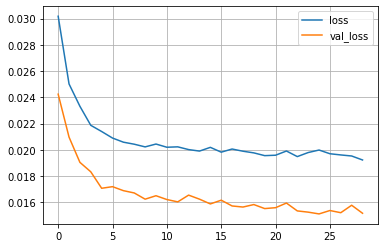

In [46]:
#Neural Network Model
METRICS = [

      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]

initial_bias = np.log([pos/neg])

output_bias = tf.keras.initializers.Constant(initial_bias)
model = keras.Sequential()
model.add(keras.layers.Dense(16, activation='relu',input_shape=(train_features.shape[-1],)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu',input_shape=(train_features.shape[-1],)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True) 


model.compile(optimizer="adam",loss="binary_crossentropy",metrics=METRICS)

train_log = model.fit(
  train_features,
  train_labels,
  epochs=50,
  batch_size=200,
  validation_split=0.2,
  callbacks=[callback]
)
model.evaluate(test_features, test_labels)
plot_loss(train_log)

In [47]:
#Save Model
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
